# LioJotstar Merger: Data Analysis with Python for Strategic Optimization

## 6. Subscription Trends: Acquisition & Demographics
This notebook analyzes user subscription trends for LioCinema and Jotstar, examining user acquisition over time, demographic distributions by age and city tier, subscription plan preferences, and plan change behaviors using grouped bar charts, line charts, population pyramids, pie charts, stacked bar charts, and heatmaps.

### Importing Required Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

### Loading Required DataFrames from Saved Parquet Files

In [6]:
try:
    jotstar_subscribers_df = pd.read_parquet('Parquet Data Files/03. Feature Engineering/Jotstar_db/subscribers.parquet')
    print("Jotstar - Subscribers table loaded successfully.")
    liocinema_subscribers_df = pd.read_parquet('Parquet Data Files/03. Feature Engineering/LioCinema_db/subscribers.parquet')
    print("LioCinema - Subscribers table loaded successfully.")
    print("\nData Loading Complete.")
    
except FileNotFoundError as e:
       print("Error: One or more Parquet files not found. Please check the file paths.")
       print(f"Details: {e}")
except Exception as e:
       print("An error occurred during data import.")
       print(f"Details: {e}")

Jotstar - Subscribers table loaded successfully.
LioCinema - Subscribers table loaded successfully.

Data Loading Complete.


### Data Analysis & Visualization

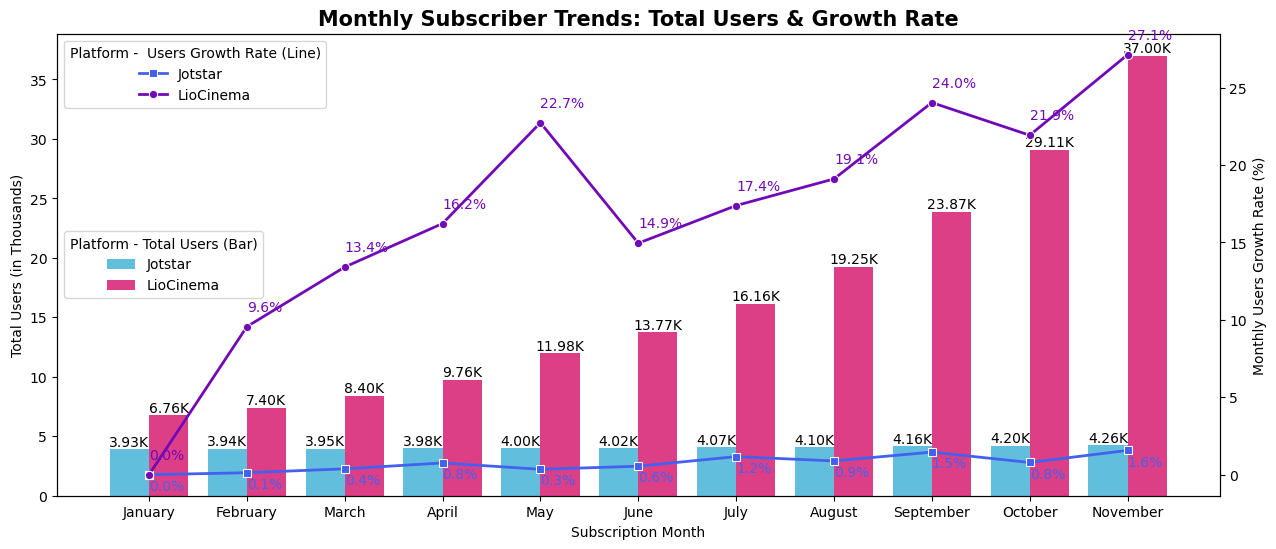

In [8]:
def get_monthly_user_growth_rate(df):
    temp_df = df[["User ID", "Subscription Date"]].copy()
    temp_df['Subscription Month Number'] = temp_df['Subscription Date'].dt.month
    temp_df['Subscription Month'] = temp_df['Subscription Date'].dt.month_name()
    result = temp_df.groupby(['Subscription Month Number', 'Subscription Month'])['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID': 'Total Users'})
    result = result.sort_index()
    # Calculate Monthly Users Growth Rate
    result['Monthly Users Growth Rate (%)'] = round(result['Total Users'].pct_change() * 100, 2)
    result['Monthly Users Growth Rate (%)'] = result['Monthly Users Growth Rate (%)'].fillna(0)
    result['Total Users'] /= 1000
    return result
    
jotstar_monthly_users_growth_rate_df = get_monthly_user_growth_rate(jotstar_subscribers_df)
liocinema_monthly_users_growth_rate_df = get_monthly_user_growth_rate(liocinema_subscribers_df)
jotstar_monthly_users_growth_rate_df['Platform'] = "Jotstar"
liocinema_monthly_users_growth_rate_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_monthly_users_growth_rate_df, liocinema_monthly_users_growth_rate_df])
merged_df = merged_df.reset_index('Subscription Month')
merged_df = merged_df.sort_index()

fig, ax1 = plt.subplots(figsize = (15, 6))
ax2 = ax1.twinx()

bp = sns.barplot(x = 'Subscription Month', y = 'Total Users', data = merged_df, hue = 'Platform', palette = ["#4CC9F0", "#F72585"], ax = ax1)
for i in bp.containers:
    bp.bar_label(i, fmt = "%.2fK")

sns.lineplot(x = 'Subscription Month', y = 'Monthly Users Growth Rate (%)', data = merged_df[merged_df['Platform'] == "Jotstar"], 
             color = "#4361EE", marker = "s", linewidth = 2, ax = ax2, label = "Jotstar")
for a, b, platform in zip(merged_df['Subscription Month'], merged_df['Monthly Users Growth Rate (%)'], merged_df['Platform']):
    if platform == "Jotstar": 
        plt.text(x = a, y = b - 1, s = f"{b:.1f}%", color = "#4361EE")

sns.lineplot(x = 'Subscription Month', y = 'Monthly Users Growth Rate (%)', data = merged_df[merged_df['Platform'] == "LioCinema"], 
             color = "#7209B7", marker = "o", linewidth = 2, ax = ax2, label = "LioCinema")
for a, b, platform in zip(merged_df['Subscription Month'], merged_df['Monthly Users Growth Rate (%)'], merged_df['Platform']):
    if platform == "LioCinema": 
        plt.text(x = a, y = b + 1, s = f"{b:.1f}%", color = "#7209B7")

plt.title("Monthly Subscriber Trends: Total Users & Growth Rate", fontsize = 15, fontweight = "bold")
ax1.grid(False)
ax2.grid(False)
ax1.legend(title = "Platform - Total Users (Bar)", loc = "center left")
ax2.legend(title = "Platform -  Users Growth Rate (Line)", loc = "upper left")
ax1.set_ylabel("Total Users (in Thousands)")

# Saving multi-row KPI to Excel for Tabular viewing
merged_df.to_excel('KPIs Excel Files/Monthly User Growth Rate.xlsx')

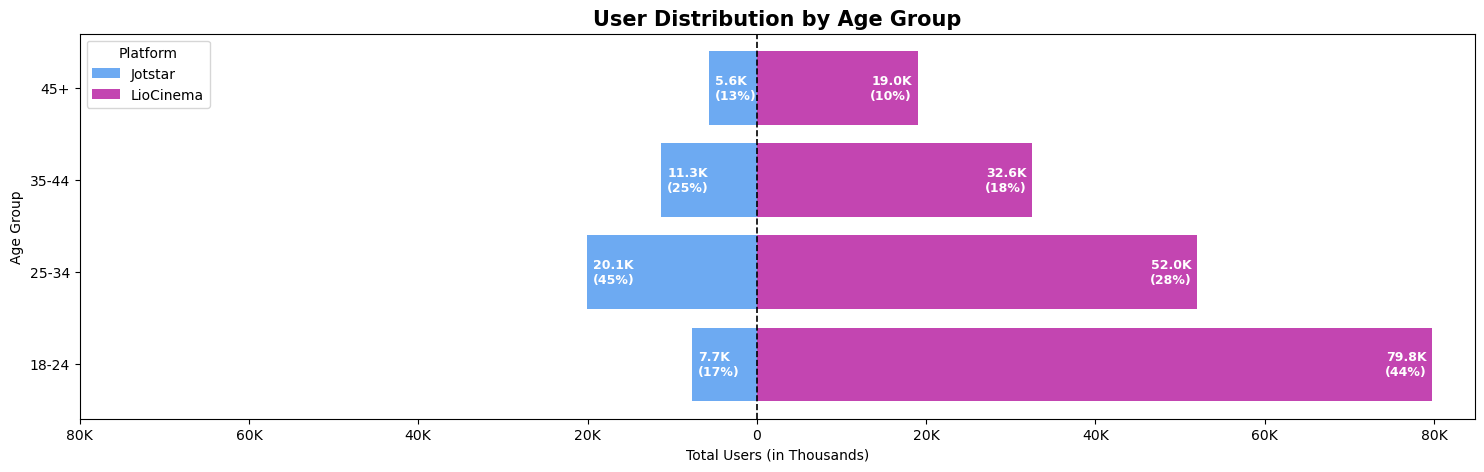

In [9]:
def get_user_count(df):
    result = df.groupby('Age Group')['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID':'Total Users'}).reset_index()
    return result
    
jotstar_temp_df = get_user_count(jotstar_subscribers_df)
jotstar_temp_df['Total Users'] *= -1
liocinema_temp_df = get_user_count(liocinema_subscribers_df)

plt.subplots(figsize = (18, 5))
plt.title("User Distribution by Age Group", fontsize = 15, fontweight = "bold")

bars_js = plt.barh(jotstar_temp_df['Age Group'], jotstar_temp_df['Total Users'], color = "#4895EF", label = "Jotstar", alpha = 0.8)

bars_lc = plt.barh(liocinema_temp_df['Age Group'], liocinema_temp_df['Total Users'], color = "#B5179E", label = "LioCinema", alpha = 0.8)

for bar in bars_js:
    value = (abs(bar.get_width())) / 1000
    pct = ((abs(bar.get_width())) / abs(jotstar_temp_df['Total Users'].sum()))* 100
    plt.text(bar.get_width() + 700, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}K\n({pct:.0f}%)", 
             va = "center", ha = "left", color = "white", fontsize = 9, fontweight = "bold")

for bar in bars_lc:
    value = (bar.get_width()) / 1000
    pct = ((bar.get_width()) / (liocinema_temp_df['Total Users'].sum()))* 100
    plt.text(bar.get_width() - 700, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}K\n({pct:.0f}%)", 
             va = "center", ha = "right", color = "white", fontsize = 9, fontweight = "bold")

plt.xlabel("Total Users (in Thousands)")
plt.ylabel("Age Group")
plt.axvline(0, color = "black", linewidth = 1.2, linestyle = "dashed")
plt.xticks(ticks = [-80000, -60000, -40000, -20000, 0, 20000, 40000, 60000, 80000], 
           labels = ["80K", "60K", "40K", "20K", "0", "20K", "40K", "60K", "80K"])
plt.legend(title = "Platform", loc = "upper left")

Text(0.5, 0, 'Total Users (in Thousands)')

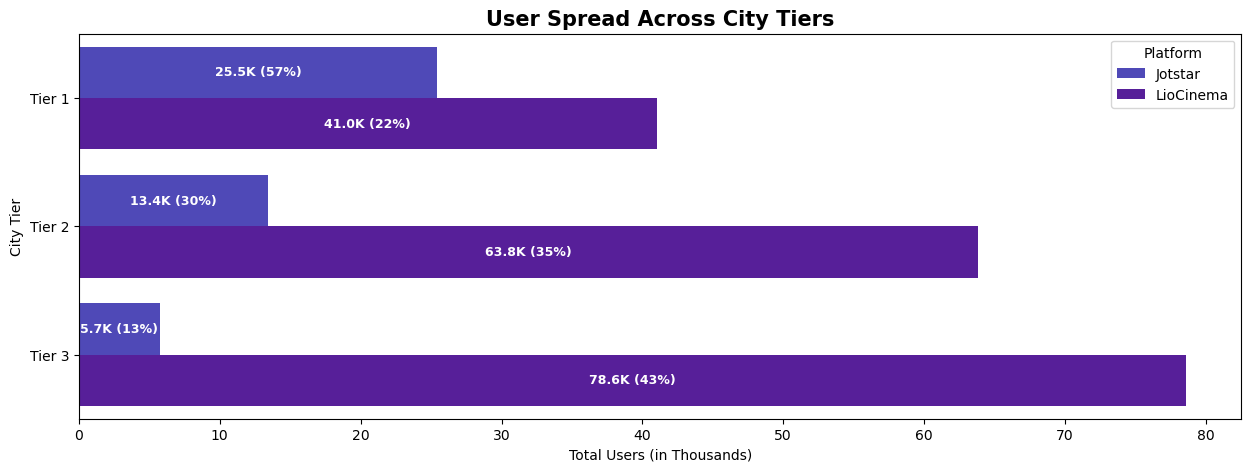

In [10]:
def get_user_count(df):
    result = df.groupby('City Tier')['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID':'Total Users'}).reset_index()
    result['Total Users (%)'] = result['Total Users'] / (result['Total Users'].sum()) * 100
    result['Total Users'] /= 1000
    return result
    
jotstar_temp_df = get_user_count(jotstar_subscribers_df)
jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df = get_user_count(liocinema_subscribers_df)
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])

plt.figure(figsize = (15, 5))
plt.title("User Spread Across City Tiers", fontsize = 15, fontweight = "bold")

bp = sns.barplot(merged_df, y = 'City Tier', x = 'Total Users', hue = 'Platform', palette = ["#3F37C9", "#560BAD"])

for bar, users, pct in zip(bp.patches, merged_df['Total Users'], merged_df['Total Users (%)']):
    x = bar.get_x() + bar.get_width() / 2  
    y = bar.get_y() + bar.get_height() / 2
    label = f"{users:.1f}K ({pct:.0f}%)"  
    plt.text(x, y, label, ha = "center", va = "center", fontsize = 9, color = "white", fontweight = "bold")

plt.xlabel("Total Users (in Thousands)")

([<matplotlib.patches.Wedge at 0x18d89ae8620>,
 [Text(-0.5112211773281881, 0.9739881456420204, 'Free'),
  Text(0.2171785468966757, -1.0783475686288946, 'Basic'),
  Text(1.055749124605438, -0.3088588446116632, 'Premium')],
 [Text(-0.27884791490628436, 0.5312662612592838, '119.9K (65%)'),
  Text(0.1184610255800049, -0.5881895828884879, '46.9K (26%)'),
  Text(0.5758631588756934, -0.1684684606972708, '16.6K (9%)')])

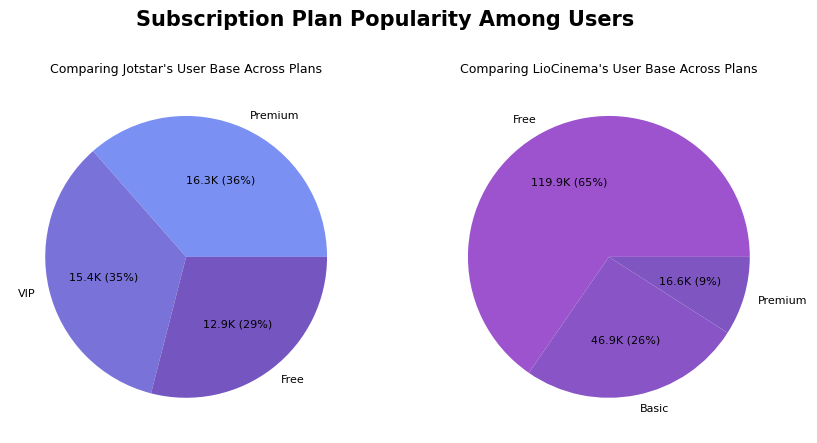

In [11]:
def get_user_count(df):
    result = df.groupby('New Subscription Plan')['User ID'].count()
    result = result.to_frame().reset_index()
    result = result.rename(columns = {'New Subscription Plan':'Subscription Plan', 'User ID':'Total Users'})
    result = result.sort_values('Total Users', ascending = False)
    result['Total Users'] /= 1000
    return result
    
jotstar_temp_df = get_user_count(jotstar_subscribers_df)
liocinema_temp_df = get_user_count(liocinema_subscribers_df)

def autopct_format(pct, all_vals):
    absolute = round((pct / 100. * sum(all_vals)), 1)
    return f"{absolute}K ({pct:.0f}%)"  

plt.figure(figsize = (10, 5))
plt.subplots_adjust(top = 0.86)
plt.suptitle("Subscription Plan Popularity Among Users", fontsize = 15, fontweight = "bold")

Jotstar = ["#7B90F3", "#7973D9", "#7555BF"]
LioCinema = ["#9C53CD", "#8954C6", "#7F55C2"]

ax1 = plt.subplot(1, 2, 1)
ax1.set_aspect("equal")
plt.title("Comparing Jotstar's User Base Across Plans", fontsize = 9)
plt.pie(jotstar_temp_df['Total Users'], labels = jotstar_temp_df['Subscription Plan'], 
        autopct = lambda pct: autopct_format(pct, jotstar_temp_df['Total Users']), 
        colors = Jotstar, textprops = {"fontsize": 8})

ax2 = plt.subplot(1, 2, 2)
ax2.set_aspect("equal")
plt.title("Comparing LioCinema's User Base Across Plans", fontsize = 9)
plt.pie(liocinema_temp_df['Total Users'], labels = liocinema_temp_df['Subscription Plan'], 
        autopct = lambda pct: autopct_format(pct, liocinema_temp_df['Total Users']), 
        colors = LioCinema, textprops = {"fontsize": 8})

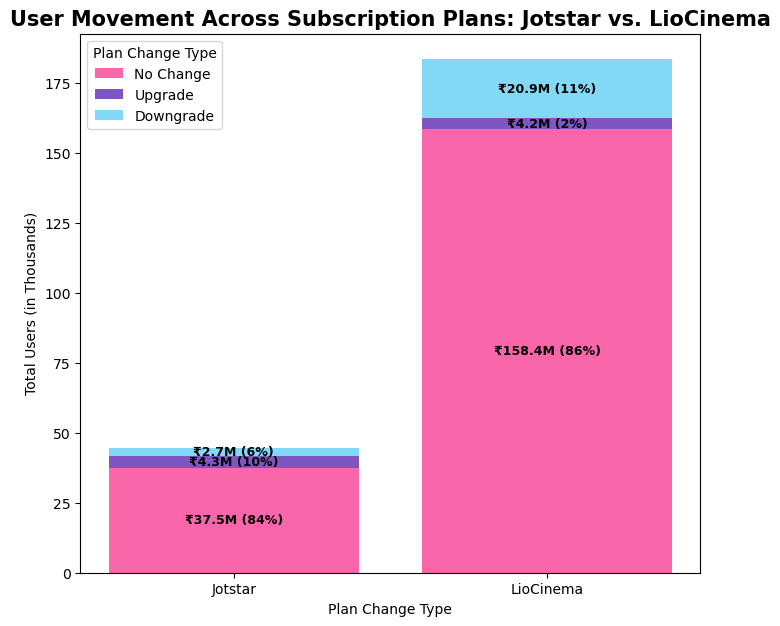

In [12]:
def get_user_count(df):
    result = df.groupby('Plan Change Type')['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID':'Total Users'}).reset_index()
    result['Total Users (%)'] = (result['Total Users'] / result['Total Users'].sum()) * 100
    result['Total Users'] /= 1000
    return result
    
jotstar_temp_df = get_user_count(jotstar_subscribers_df)
liocinema_temp_df = get_user_count(liocinema_subscribers_df)
jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])

pivot_df = merged_df.pivot(index = 'Platform', columns = 'Plan Change Type', values = ['Total Users', 'Total Users (%)']).fillna(0)

total_users = pivot_df['Total Users']
total_users_pct = pivot_df['Total Users (%)']

fig, ax = plt.subplots(figsize = (8, 7))

bars_nc = ax.bar(total_users.index, total_users.get("No Change", 0), color = "#F966AA", label = "No Change")

bars_up = ax.bar(total_users.index, total_users.get("Upgrade", 0), 
                 bottom = total_users.get("No Change", 0), 
                 color = "#7F55C2", label = "Upgrade")

bars_down = ax.bar(total_users.index, total_users.get("Downgrade", 0), 
                   bottom = total_users.get("No Change", 0) + total_users.get("Upgrade", 0), 
                   color = "#82D9F5", label = "Downgrade")

for bars, plan_type in zip([bars_nc, bars_up, bars_down], ["No Change", "Upgrade", "Downgrade"]):
    for bar, pct in zip(bars, total_users_pct.get(plan_type, [0] * len(bars))):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,  
                    f"₹{height:.1f}M ({pct:.0f}%)",  
                    ha = "center", va = "center", color = "black", fontsize = 9, fontweight = "bold")

ax.set_xlabel("Plan Change Type")
ax.set_ylabel("Total Users (in Thousands)")
ax.set_title("User Movement Across Subscription Plans: Jotstar vs. LioCinema", fontsize = 15, fontweight = "bold")
ax.legend(title = "Plan Change Type", loc = "best")

<Axes: title={'center': 'LioCinema: Paid Subscription Breakdown by City Tier'}, xlabel='City Tier', ylabel='Subscription Plan'>

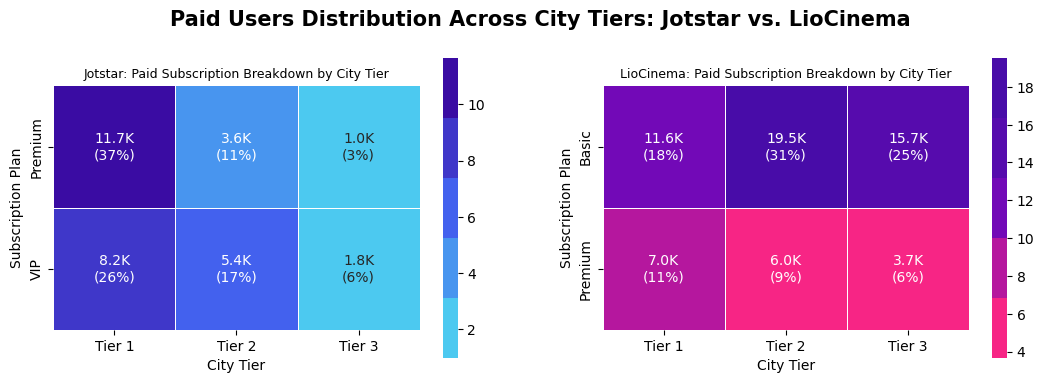

In [13]:
def get_user_count(df):
    result = df.groupby(['City Tier', 'New Subscription Plan'])['User ID'].count().reset_index()
    result = result.rename(columns = {'New Subscription Plan':'Subscription Plan', 'User ID':'Total Users'})
    result['Total Users (%)'] = (result['Total Users'] / (result['Total Users'].sum()))* 100
    result['Total Users'] /= 1000
    return result
    
jotstar_temp_df = get_user_count(jotstar_subscribers_df[jotstar_subscribers_df['New Subscription Plan'] != "Free"])
liocinema_temp_df = get_user_count(liocinema_subscribers_df[liocinema_subscribers_df['New Subscription Plan'] != "Free"])

plt.figure(figsize = (13, 4))
plt.subplots_adjust(top = 0.86)
plt.suptitle("Paid Users Distribution Across City Tiers: Jotstar vs. LioCinema", fontsize = 15, fontweight = "bold")

Jotstar = ["#4CC9F0", "#4895EF", "#4361EE", "#3F37C9", "#3A0CA3"]
LioCinema = ["#F72585", "#B5179E", "#7209B7", "#560BAD", "#480CA8"]

def custom_label(val, pct):
    if pd.isna(val) or pd.isna(pct):  
        return ""  
    return f"{val:.1f}K\n({pct:.0f}%)"

jotstar_values = jotstar_temp_df.pivot_table(columns = 'City Tier', index = 'Subscription Plan', values = 'Total Users')
jotstar_pct = jotstar_temp_df.pivot_table(columns = 'City Tier', index = 'Subscription Plan', values = 'Total Users (%)')

liocinema_values = liocinema_temp_df.pivot_table(columns = 'City Tier', index = 'Subscription Plan', values = 'Total Users')
liocinema_pct = liocinema_temp_df.pivot_table(columns = 'City Tier', index = 'Subscription Plan', values = 'Total Users (%)')

jotstar_annot = jotstar_values.map(lambda x: f"{x:.1f}K") + "\n" + jotstar_pct.map(lambda x: f"({x:.0f}%)")
liocinema_annot = liocinema_values.map(lambda x: f"{x:.1f}K") + "\n" + liocinema_pct.map(lambda x: f"({x:.0f}%)")

ax1 = plt.subplot(1, 2, 1)
ax1.set_aspect("equal")
plt.title("Jotstar: Paid Subscription Breakdown by City Tier", fontsize = 9)
sns.heatmap(jotstar_values, annot = jotstar_annot, cmap = ListedColormap(Jotstar), fmt = "", linewidths = 0.5)

ax2 = plt.subplot(1, 2, 2)
ax2.set_aspect("equal")
plt.title("LioCinema: Paid Subscription Breakdown by City Tier", fontsize = 9)
sns.heatmap(liocinema_values, annot = liocinema_annot, cmap = ListedColormap(LioCinema), fmt = "", linewidths = 0.5)

## Next Notebook: "7. Decoding User Inactivity: A Deep Dive into Engagement Gaps"